In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import os
import pickle
from torch.utils.data import TensorDataset, DataLoader
import torch

In [13]:
import importlib
import utils

importlib.reload(utils)

from utils import *

print("🔧 Utils and dependencies imported")
device = get_device()

🔧 Utils and dependencies imported
🚀 Using Apple Silicon GPU (MPS)


- In the initial phase we divided the work such that each member would explore one of these toolkits for working with MIDI files
  - Mido: Payal
  - Pretty Midi: Sean
  - [Music21](https://www.music21.org/music21docs/): Antonio



# Music 21 exploration
During the exploration of music21 library and report on its advantages and disadvantages. For this purpose, a small convolutional model was created exploring different configurations of CNN and LSTM layers. Some initial investigation already pointed out that this library is more oriented towards analyzing, searching, and transforming music in symbolic (score-based) forms, and it seems to work best if the workflow is to transform MIDI files into forms where we would analyze harmony/rythm/notation. `Music21 does not have native piano roll support`.

##### Reference
Cuthbert, Michael & Ariza, Christopher. (2010). Music21: A Toolkit for Computer-Aided Musicology and Symbolic Music Data.. Proceedings of the 11th International Society for Music Information Retrieval Conference, ISMIR 2010. 637-642. 

### Downloading the dataset
For consistency, and in order not to need to commit our data files to github, `download_dataset()` was created. This utility function will automatically download the MIDI dataset from Kaggle, extract it to a local directory, and remove any files or folders not corresponding to the target composers, ensuring that everyone works with the same data structure and content.

In [2]:
paths = download_dataset()
paths

Dataset downloaded and extracted to ../data/kaggle/midiclassics


{'path': '/Users/arr/.cache/kagglehub/datasets/blanderbuss/midi-classic-music/versions/1',
 'zip_path': '/Users/arr/.cache/kagglehub/datasets/blanderbuss/midi-classic-music/versions/1/midiclassics.zip',
 'extract_path': '../data/kaggle/midiclassics'}

In [3]:
piano_rolls, valid_labels = extract_music21_piano_roll_segments(paths['extract_path'])

  9%|▉         | 44/481 [00:30<03:56,  1.85it/s]/Users/arr/miniconda3/envs/ds_base/lib/python3.12/site-packages/music21/midi/translate.py:922: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=0, data=b'Preludiul nr.3 \xeen re minor, BWV 935'>; getting generic Instrument
  warnings.warn(
 19%|█▊        | 90/481 [01:17<08:25,  1.29s/it]/Users/arr/miniconda3/envs/ds_base/lib/python3.12/site-packages/music21/midi/translate.py:922: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=0, data=b'Preludiul nr.6 \xeen mi minor, BWV 938'>; getting generic Instrument
  warnings.warn(
 26%|██▌       | 124/481 [01:45<05:08,  1.16it/s]/Users/arr/miniconda3/envs/ds_base/lib/python3.12/site-packages/music21/midi/translate.py:922: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=0, data=b'Concerto pour violon et orchestre en R\xe9 majeur'>; 

Extracted 481 piano rolls.


In [6]:
import collections
label_counts = collections.Counter(valid_labels)
composer_names = ['Bach', 'Beethoven', 'Chopin', 'Mozart']
for idx, name in enumerate(composer_names):
    print(f"{name}: {label_counts.get(idx, 0)} samples")

Bach: 122 samples
Beethoven: 133 samples
Chopin: 136 samples
Mozart: 90 samples


Taking a look at the piano roll

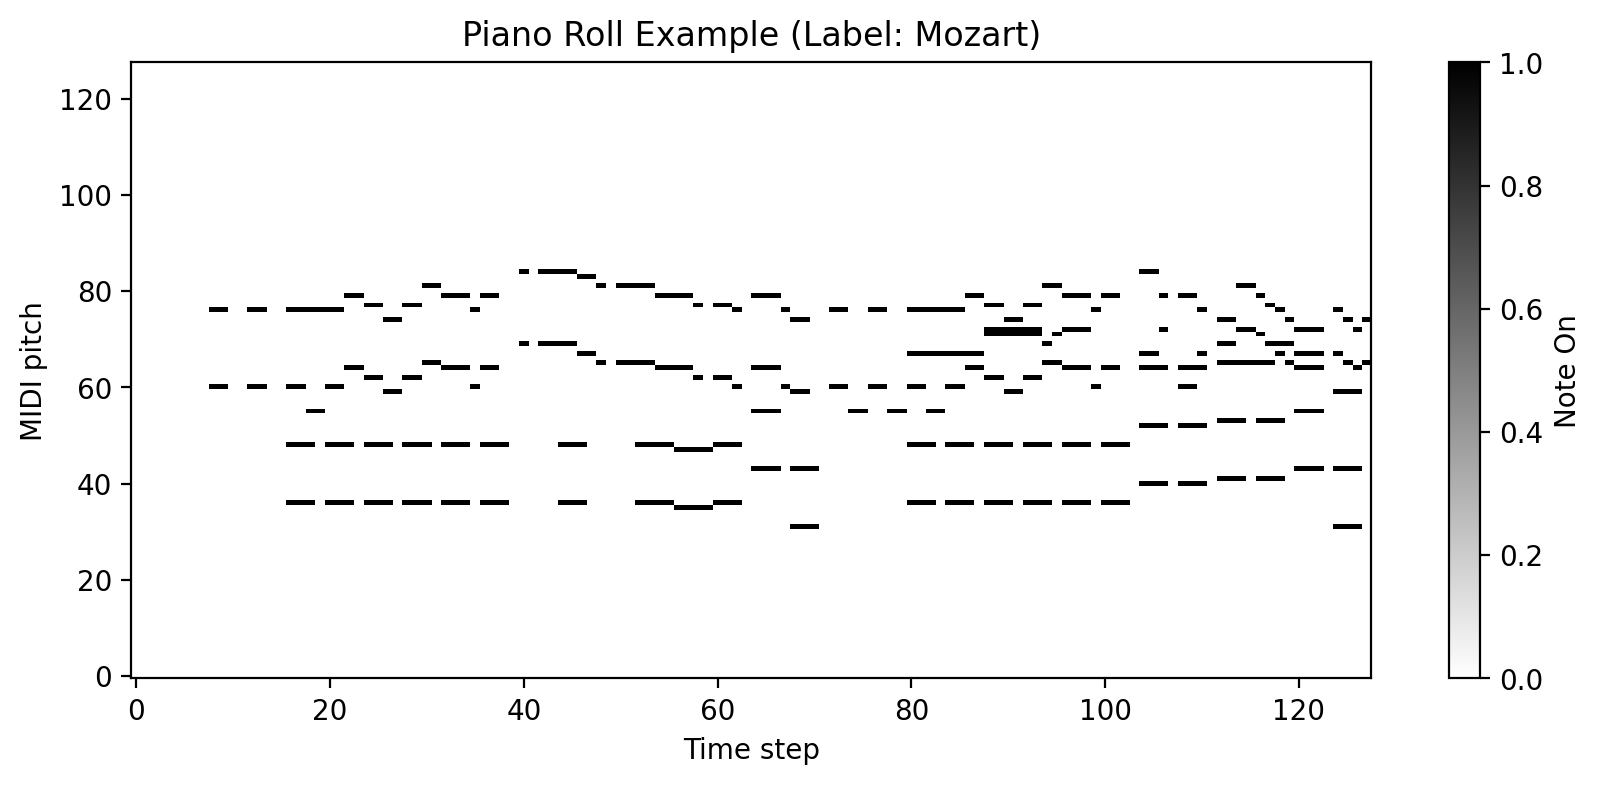

In [7]:
idx = np.random.randint(len(piano_rolls))
plt.figure(figsize=(10, 4))
plt.imshow(piano_rolls[idx], aspect='auto', origin='lower', cmap='gray_r')
plt.xlabel("Time step")
plt.ylabel("MIDI pitch")
plt.title(f"Piano Roll Example (Label: {composer_names[valid_labels[idx]]})")
plt.colorbar(label='Note On')
plt.show()

In [8]:
note_density = [np.mean(np.array(p) > 0) for p in piano_rolls]
for i, name in enumerate(composer_names):
    densities = [note_density[j] for j in range(len(valid_labels)) if valid_labels[j] == i]
    print(f"{name} - Avg. note density: {np.mean(densities):.4f}")

Bach - Avg. note density: 0.0112
Beethoven - Avg. note density: 0.0108
Chopin - Avg. note density: 0.0089
Mozart - Avg. note density: 0.0088


The initial base test is with this type of architecture with 2 CNN layers and 1 LSTM layer. The plan is to observe and try to gain any insights as to which the best next steps would be

In [14]:
class SimpleCNNLSTM(nn.Module):
    def __init__(self, num_classes, input_time_dim):
        super(SimpleCNNLSTM, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=(3,3), padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(32, 64, kernel_size=(3,3), padding=1)
        self.relu2 = nn.ReLU()
        self.pool = nn.MaxPool2d((2,2))
        # After pooling, pitch dim is 64, time dim is input_time_dim//2
        self.lstm = nn.LSTM(input_size=64, hidden_size=64, batch_first=True)
        self.fc = nn.Linear(64, num_classes)

    def forward(self, x):
        # x: (batch, 1, 128, T)
        x = self.relu1(self.conv1(x))
        x = self.pool(x)
        x = self.relu2(self.conv2(x))
        x = self.pool(x)  # Now (batch, 64, 32, T//4)
        # Prepare for LSTM: collapse pitch, transpose to (batch, time, features)
        x = x.mean(dim=2)  # (batch, 64, T//4)
        x = x.permute(0,2,1)  # (batch, T//4, 64)
        out, _ = self.lstm(x)  # (batch, T//4, 64)
        out = out[:,-1,:]      # Take last time step
        out = self.fc(out)
        return out

In [15]:
# Convert to tensors and add channel dimension (N, 1, 128, T)
X = torch.tensor(piano_rolls, dtype=torch.float32).unsqueeze(1)
y = torch.tensor(valid_labels, dtype=torch.long)

# Split into train/val sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Create DataLoaders
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=32, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=32)

In [16]:
num_classes = 4
input_time_dim = X.shape[-1]
model = SimpleCNNLSTM(num_classes=num_classes, input_time_dim=input_time_dim).to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

EPOCHS = 20
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for piano_rolls, labels in train_loader:
        piano_rolls, labels = piano_rolls.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(piano_rolls)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {total_loss/len(train_loader):.4f}")

Epoch 1/20, Loss: 1.3923
Epoch 2/20, Loss: 1.3826
Epoch 3/20, Loss: 1.3767
Epoch 4/20, Loss: 1.3809
Epoch 5/20, Loss: 1.3751
Epoch 6/20, Loss: 1.3754
Epoch 7/20, Loss: 1.3755
Epoch 8/20, Loss: 1.3748
Epoch 9/20, Loss: 1.3751
Epoch 10/20, Loss: 1.3749
Epoch 11/20, Loss: 1.3755
Epoch 12/20, Loss: 1.3784
Epoch 13/20, Loss: 1.3759
Epoch 14/20, Loss: 1.3748
Epoch 15/20, Loss: 1.3756
Epoch 16/20, Loss: 1.3758
Epoch 17/20, Loss: 1.3750
Epoch 18/20, Loss: 1.3751
Epoch 19/20, Loss: 1.3749
Epoch 20/20, Loss: 1.3759


In [17]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for piano_rolls, labels in val_loader:
        piano_rolls, labels = piano_rolls.to(device), labels.to(device)
        outputs = model(piano_rolls)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f"Validation Accuracy: {100 * correct / total:.2f}%")

Validation Accuracy: 27.84%


TODO:

## Music21 conclusion
After investigating and exploring the use of [music21](https://www.music21.org/music21docs/) as an alternative to create our piano rolls for CNN training, we noticed that there are important differences in music21 that made us decide to go with pretty_midi.

We chose **pretty_midi** for my piano-roll CNN pipeline because:
- The library is explicitly geared toward *easy MIDI modification and data extraction*, as documented.
- It provides a built-in `get_piano_roll()` function, delivering arrays directly usable in CNNs.

While **music21** is powerful for symbolic and musicological tasks, it’s not optimized for rapid MIDI-to-array conversion pipelines. We're planning on using CNNs for feature extraction, therefore pretty_midi looks like the right choice

#### Model results
- After comparing the initial trials among all the alternatives, the pretty_midi example performed much better than the simple implementation using music21, therefore, we decided to commit to `pretty_midi`

# Next steps
The group decided to work in separate parallel attempts at getting the best performance, all members focusing on different things:
- Payal focused on ......
- Sean focused on .....
- Antonio focused on multi-modality, where CNN layers would do feature extraction, and a separate non-sequential layer would use extracted engineered features to find some patterns, then later joining the two as input for LSTM layers. The inspiration for this came from a YouTube video explaining how the LLM models are easier to train in the Chinese language when using multimodality ([link to video](https://youtube.com/shorts/AQrRfqEVpic?si=ihqV33mBX9kqla07)).

##### Reference
Sun, Z., Li, X., Sun, X., Meng, Y., Ao, X., He, Q., Wu, F., & Li, J. (2021). ChineseBERT: Chinese pretraining enhanced by glyph and Pinyin information (arXiv:2106.16038). arXiv. https://doi.org/10.48550/arXiv.2106.16038

# CNN-MLP Multimodal Composer Classification

Upon reading the course slack messages, and seeing that some students reported good results when creating separate CNN and LSTM models, then ensembling them, this model was created to replicate that attempt. Apart from passing the piano roll through convolutional layers like before, this model also introduced separate MLP (Multilayer Perceptron) layers to learn from features that were engineering by extracting musical features from the piano_roll data. This way, the model can mimic the multi-modality described in the [youtube video](https://youtube.com/shorts/AQrRfqEVpic?si=ihqV33mBX9kqla07) mentioned in the section above.

## Model Architecture
- **CNN Stream**: Processes piano roll data for visual pattern recognition
- **MLP Stream**: Processes hand-crafted musical features
- **Fusion Layer**: Combines both streams for final classification

In [ ]:
# %pip install pretty_midi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 89.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 5.6 MB/s eta 0:00:00
  Created wheel for pretty_midi: filename=pretty_midi-0.2.10-py3-none-any.whl size=5592286 sha256=b1749eaff8b99bb58cfcccc8eb0d3253865bf586e5a7390b6681ff435db5abd2
  Stored in directory: /root/.cache/pip/wheels/e6/95/ac/15ceaeb2823b04d8e638fd1495357adb8d26c00ccac9d7782e
Successfully built pretty_midi


We'll download the dataset and start from scratch like before

In [6]:
# download dataset
paths = download_dataset()

Dataset downloaded and extracted to data/kaggle/midiclassics


## Loading piano roll music files

For this particular model, in order to prepare the piano roll data, the `load_segmented_dataset_no_overlap` function was created.
It uses pretty_midi to load and process MIDI files for each target composer. The function performs the following steps:

1. MIDI Loading and Segmentation:
For each MIDI file, it uses pretty_midi to extract the full piano roll and then splits the music into non-overlapping segments of a specified duration (e.g., 20 seconds). This segmentation increases the number of training samples and ensures that each segment is a distinct, contiguous part of the music.

2. Piano Roll Extraction and Normalization:
Each segment is converted into a piano roll matrix (notes × time) using pretty_midi, and normalization is applied to standardize the data (such as focusing on the active pitch range).

3. Feature Extraction:
For every segment, the function computes a set of musical features (e.g., note density, pitch range, rhythmic patterns) that can be used for multi-modal or feature-based models.

4. Quality Filtering:
Segments that are too sparse (with very few notes) are filtered out to ensure only musically meaningful data is included.

5. Class Balancing (Song-aware):
The function balances the number of segments per composer by either downsampling or oversampling at the song level. This ensures that all segments from a single song are kept together in either the training or validation set, preventing data leakage.

6. Caching:
The processed dataset is cached to disk for faster loading in future runs. If the cache exists, it loads the data directly from cache.

### Output:
The function returns:

- data: numpy array of piano roll segments (samples × notes × time)
- labels: numpy array of integer labels (composer indices)
- features: list of feature dictionaries for each segment
- song_ids: list of unique identifiers for each segment (song and segment index)

### In summary:
`load_segmented_dataset_no_overlap` uses pretty_midi to segment, normalize, extract features, filter, balance, and cache a dataset of MIDI files, returning arrays and features ready for machine learning and deep learning experiments.

In [19]:
TARGET_COMPOSERS = ['Bach', 'Beethoven', 'Chopin', 'Mozart']
data, labels, features, song_ids = load_segmented_dataset_no_overlap(paths["extract_path"], TARGET_COMPOSERS)

LOADING DATASET WITH NON-OVERLAPPING SEGMENTATION...
Segment duration: 20.0s with NO OVERLAP
Balance classes: True
Loading segmented dataset from cache: ../local_cache/segmented_dataset_no_overlap_20.0.pkl


In [20]:
song_ids[0:5] # For example: ['Bach_0_0', 'Bach_0_1', 'Bach_0_2', 'Bach_0_3', 'Bach_0_4']

['data/kaggle/midiclassics/Bach/Bwv0997 Partita for Lute 1mov.mid__0',
 'data/kaggle/midiclassics/Bach/Bwv0997 Partita for Lute 1mov.mid__1',
 'data/kaggle/midiclassics/Bach/Bwv0997 Partita for Lute 1mov.mid__2',
 'data/kaggle/midiclassics/Bach/Bwv0997 Partita for Lute 1mov.mid__3',
 'data/kaggle/midiclassics/Bach/Bwv0997 Partita for Lute 1mov.mid__4']

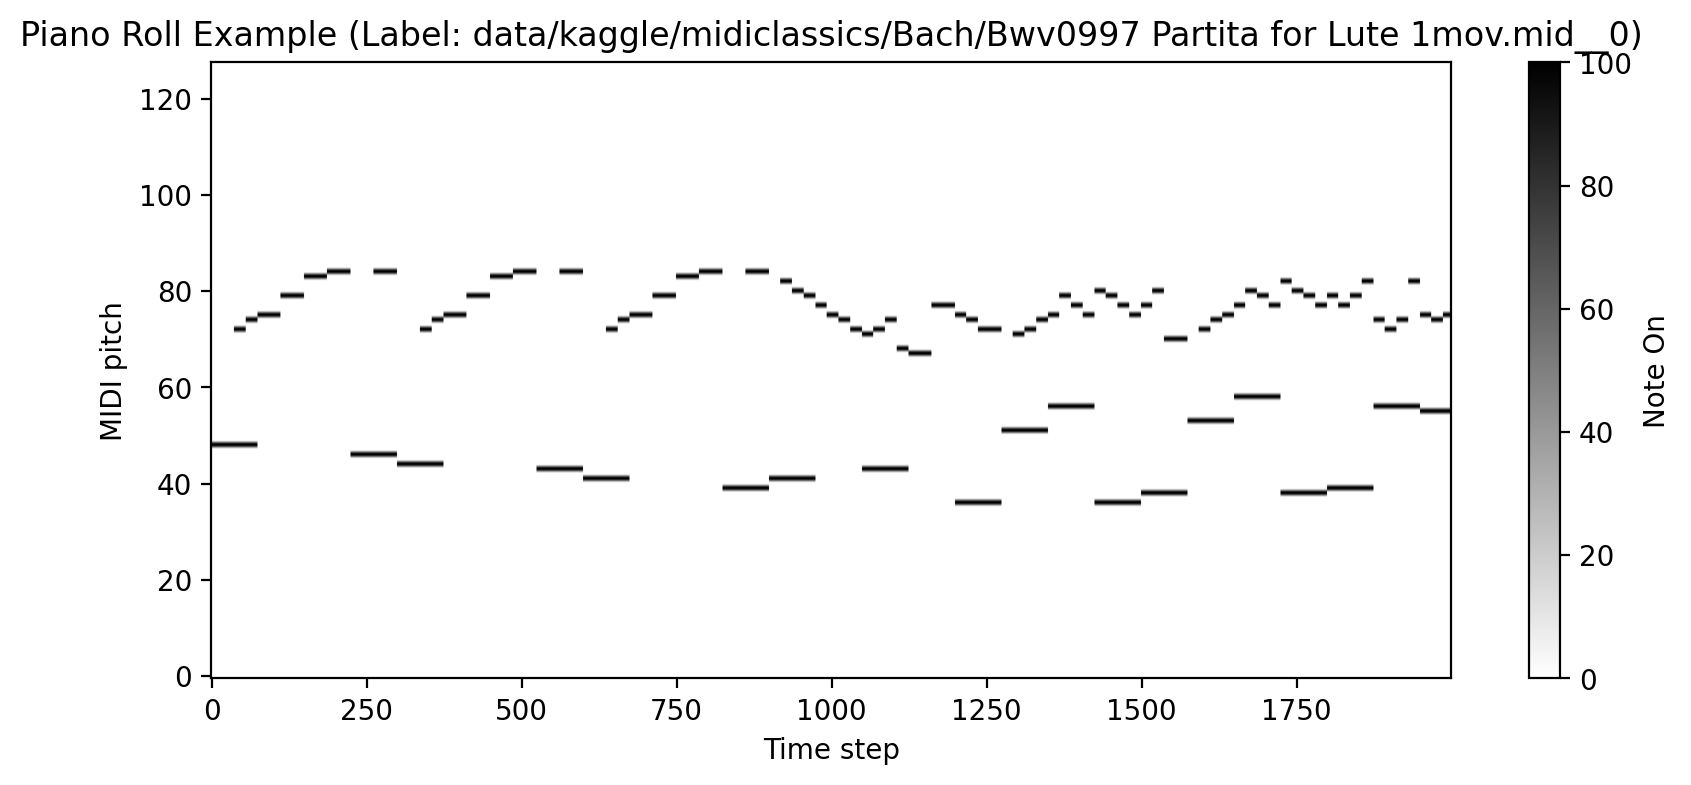

In [24]:
# plot the piano roll for the first song
plt.figure(figsize=(10, 4))
plt.imshow(data[0], aspect='auto', origin='lower', cmap='gray_r')
plt.xlabel("Time step")
plt.ylabel("MIDI pitch")
plt.title(f"Piano Roll Example (Label: {song_ids[0]})")
plt.colorbar(label='Note On')
plt.show()

## Loading engineered features
In order to add multimodality to the model, part of the network will process musical features extracted from each file. The aim is to have features that have statistical significance and have the network associate them with certain convolutional patterns.


The load `load_comprehensive_features` function uses `extract_comprehensive_musical_features` internally to generate a detailed, normalized feature vector for each piano roll, capturing temporal, harmonic, dynamic, and stylistic aspects of the music. This enables more interpretable and multi-modal machine learning models. It works as follows:

- Caching:
To speed up training. If we've computed these features before, pull them from a file. Else, after computing the features, it saves them.

- Feature Extraction:
It computes features for each piano roll by calling the `extract_comprehensive_musical_features` function. The results are then cached for future use.

### Features Extracted by extract_comprehensive_musical_features
For each piano roll, the following features are extracted:

#### Temporal/Rhythmic Features

- `avg_notes_per_time`: Average number of notes played per time step.
- `note_density_variance`: Variance of note density over time.
- `note_density_std`: Standard deviation of note density over time.
- `max_simultaneous_notes`: Maximum number of notes played at once.
- `onset_density`: Frequency of new note onsets.
- `silence_ratio`: Fraction of time steps with no notes played.
- `temporal_sparsity`: Proportion of time steps with no activity.
- `activity_bursts`: Frequency of bursts of musical activity.


#### Pitch/Harmonic Features

- `pitch_range`: Number of unique pitches used.
- `lowest_pitch`: Lowest pitch played.
- `highest_pitch`: Highest pitch played.
- `pitch_span`: Difference between highest and lowest pitch.
- `pitch_centroid`: Weighted average pitch (center of gravity).
- `pitch_variance`: Variance of pitch activity.
- `bass_activity`: Fraction of notes in the bass register (A0–B2).
- `mid_activity`: Fraction of notes in the mid register (C3–B4).
- `treble_activity`: Fraction of notes in the treble register (C5–B7).


#### Other Harmonic Features

- `chord_ratio`: Fraction of time steps with chords (3+ notes).
- `single_note_ratio`: Fraction of time steps with only one note.
- `polyphony_complexity`: Average number of notes played when there is activity.
- `avg_chord_size`: Average number of notes in a chord.
- `chord_variance`: Variance in chord sizes.


#### Velocity/Dynamics Features

- `avg_velocity`: Average note velocity (intensity).
- `velocity_variance`: Variance of note velocities.
- `velocity_range`: Range of velocities.
- `dynamic_complexity`: Diversity of velocities used.


#### Style-Specific Features

- `overall_density`: Fraction of the piano roll that is active (notes played).
- `rhythmic_regularity`: Inverse of note density variance (higher means more regular rhythm).
- `pitch_movement_variance`: Variance in the movement of pitch centers over time.
- `melodic_direction_changes`: Frequency of changes in melodic direction.

Our feature extraction approach is aligned with established practices in Music Information Retrieval (MIR) and related pattern recognition tasks, where the goal is to capture multiple aspects of the signal through diverse features. As noted in Dell’Aversana et al. (2016):

> “Pattern recognition is commonly based on the extraction of several features from the data. A feature is a specific piece of information that can be used for characterizing the data itself.” (p. 414)

MIR research commonly groups musical features into categories that match the design of `extract_comprehensive_musical_features`:

> “Musical features typically fall into one of three main categories: low-level, high-level and cultural features. Spectral or time-domain information… belong to the first category. Melodic contour, chord frequencies and rhythmic properties are typical examples of high-level features.” (p. 414)

A major benefit of symbolic formats such as MIDI is their ability to store richer descriptors:

> “Many new attributes can be introduced… after transforming… into MIDI format… symbolic representations… can store high-level musical information… rhythmic, melodic and harmonic patterns, chord sequences and other significant structures.” (p. 417)

Empirical results show that including such high-level, polyphonic features improves classification outcomes:

> “When also ‘high-level’ MIDI features are included (such as rhythmic, melodic and harmonic multi-valued features), the classification performance improves in terms of cluster separation.” (p. 425)

By incorporating temporal, harmonic, dynamic, and stylistic descriptors, our feature set follows the same principle: using a broad, multi-level representation to improve the interpretability and performance of downstream machine learning models.



### References

Dell’Aversana, P., Gabbriellini, G., Marini, A. I., & Amendola, A. (2016). Application of Musical Information Retrieval (MIR) techniques to seismic facies classification: Examples in hydrocarbon exploration. *AIMS Geosciences, 2*(4), 413–425. https://doi.org/10.3934/geosci.2016.4.413

In [ ]:
# gets the extracted features for multi-modal learning
comprehensive_features = load_comprehensive_features(data)

✅ Saved comprehensive_features to cache: local_cache/comprehensive_musical_features.pkl


There were multiple iterations of this model, but this was the one that gave us the best result. Among the many attemps, we also tried leakyReLU, but ReLU worked better

In [29]:
class MultimodalComposerClassifier(nn.Module):
    """
    Multimodal architecture combining CNN (piano rolls) + MLP (musical features)
    """
    def __init__(self, num_classes=4, num_features=None):
        super(MultimodalComposerClassifier, self).__init__()

        # CNN Stream for Piano Rolls (visual patterns)
        self.cnn_stream = nn.Sequential(
            # Block 1
            nn.Conv2d(1, 32, kernel_size=(3, 3), padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(), # <--- we also tried LeakyReLU, given that piano rolls are sparse, but ReLU worked better
            nn.Conv2d(32, 32, kernel_size=(3, 3), padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout2d(0.2),
            nn.MaxPool2d(kernel_size=(2, 2)),

            # Block 2
            nn.Conv2d(32, 64, kernel_size=(3, 3), padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=(3, 3), padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout2d(0.3),
            nn.MaxPool2d(kernel_size=(2, 2)),

            # Block 3
            nn.Conv2d(64, 128, kernel_size=(3, 3), padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=(3, 3), padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout2d(0.4),
            nn.MaxPool2d(kernel_size=(2, 2)),

            # Global pooling instead of LSTM
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten()
        )

        # MLP Stream for Musical Features (hand-crafted features)
        self.mlp_stream = nn.Sequential(
            nn.Linear(num_features, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.1)
        )

        # Fusion Layer (combine both streams)
        self.fusion = nn.Sequential(
            nn.Linear(128 + 32, 256),  # 128 from CNN + 32 from MLP
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, num_classes)
        )

    def forward(self, piano_roll, features):
        cnn_features = self.cnn_stream(piano_roll) # piano rolls go through CNN
        mlp_features = self.mlp_stream(features) # hand-crafted features go through MLP
        combined = torch.cat([cnn_features, mlp_features], dim=1) # we put the outputs together for multimodality
        output = self.fusion(combined) # Now, we fuse the two streams into a final layer and classify
        return output

Given the computational cost, we have not tried hyper parameter tuning, nor explored different optimizers, however, learning rate was tweaked

In [ ]:
num_classes = len(TARGET_COMPOSERS)
num_features = len(comprehensive_features[0])
model = MultimodalComposerClassifier(num_classes=num_classes, num_features=num_features).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.7)

In [15]:
train_loader, val_loader = create_songwise_data_loaders(
    data,
    labels,
    comprehensive_features,
    song_ids,
    batch_size=32,
    train_split=0.8,
    dataset_class=MultimodalDataset
)

📊 Feature Processing:
• Feature names: ['avg_notes_per_time', 'note_density_variance', 'note_density_std', 'max_simultaneous_notes', 'onset_density']...
• Features normalized: mean≈0, std≈1
✅ Multimodal Dataset Created:
• Piano rolls: torch.Size([7305, 128, 2000])
• Features: torch.Size([7305, 30])
• Labels: torch.Size([7305])
• Total samples: 7305
📊 Feature Processing:
• Feature names: ['avg_notes_per_time', 'note_density_variance', 'note_density_std', 'max_simultaneous_notes', 'onset_density']...
• Features normalized: mean≈0, std≈1
✅ Multimodal Dataset Created:
• Piano rolls: torch.Size([1827, 128, 2000])
• Features: torch.Size([1827, 30])
• Labels: torch.Size([1827])
• Total samples: 1827
📊 Songwise Data Loaders Created:
• Training samples: 7305
• Validation samples: 1827
• Batch size: 32


In [16]:
EPOCHS = 40
train_losses, val_accuracies = train_cnn_mlp_model(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    scheduler,
    epochs=EPOCHS,
    device=device
)

[CNN-MLP] Epoch [1/40], Loss: 1.0743, Val Acc: 65.79%
[CNN-MLP] Epoch [2/40], Loss: 0.8239, Val Acc: 72.19%
[CNN-MLP] Epoch [3/40], Loss: 0.7424, Val Acc: 74.82%
[CNN-MLP] Epoch [4/40], Loss: 0.6899, Val Acc: 77.94%
[CNN-MLP] Epoch [5/40], Loss: 0.6579, Val Acc: 78.98%
[CNN-MLP] Epoch [6/40], Loss: 0.6186, Val Acc: 81.39%
[CNN-MLP] Epoch [7/40], Loss: 0.5987, Val Acc: 82.87%
[CNN-MLP] Epoch [8/40], Loss: 0.5794, Val Acc: 82.70%
[CNN-MLP] Epoch [9/40], Loss: 0.5596, Val Acc: 83.31%
[CNN-MLP] Epoch [10/40], Loss: 0.5407, Val Acc: 83.80%
[CNN-MLP] Epoch [11/40], Loss: 0.5136, Val Acc: 84.78%
[CNN-MLP] Epoch [12/40], Loss: 0.4955, Val Acc: 85.06%
[CNN-MLP] Epoch [13/40], Loss: 0.4953, Val Acc: 85.11%
[CNN-MLP] Epoch [14/40], Loss: 0.4785, Val Acc: 86.43%
[CNN-MLP] Epoch [15/40], Loss: 0.4628, Val Acc: 87.19%
[CNN-MLP] Epoch [16/40], Loss: 0.4463, Val Acc: 86.81%
[CNN-MLP] Epoch [17/40], Loss: 0.4473, Val Acc: 86.86%
[CNN-MLP] Epoch [18/40], Loss: 0.4354, Val Acc: 87.41%
[CNN-MLP] Epoch [19

🔍 EVALUATING MODEL...

📊 CLASSIFICATION REPORT:
              precision    recall  f1-score   support

        Bach     0.9491    0.9147    0.9316       469
   Beethoven     0.8684    0.8665    0.8675       457
      Chopin     0.9342    0.9537    0.9439       432
      Mozart     0.8933    0.9104    0.9018       469

    accuracy                         0.9108      1827
   macro avg     0.9113    0.9113    0.9112      1827
weighted avg     0.9111    0.9108    0.9108      1827



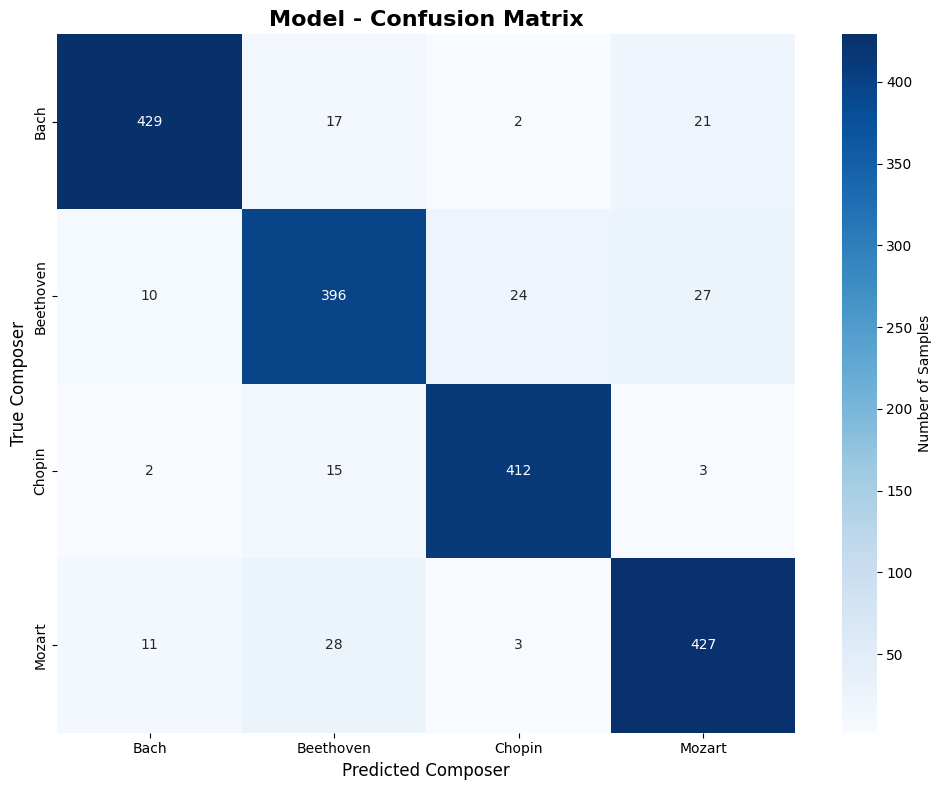


🎯 PER-CLASS ACCURACY:
Bach        : 0.9147 (91.47%)
Beethoven   : 0.8665 (86.65%)
Chopin      : 0.9537 (95.37%)
Mozart      : 0.9104 (91.04%)

🏆 OVERALL ACCURACY: 0.9108 (91.08%)

❌ MOST CONFUSED PAIRS:
Mozart → Beethoven: 28 samples
Beethoven → Mozart: 27 samples
Beethoven → Chopin: 24 samples
Bach → Mozart: 21 samples
Bach → Beethoven: 17 samples


In [17]:
results = evaluate_model_comprehensive(model, val_loader, TARGET_COMPOSERS, device)

In [ ]:
# Create the directory if it doesn't exist
save_dir = '../saved_models'
os.makedirs(save_dir, exist_ok=True)

# Save the model
torch.save(model.state_dict(), os.path.join(save_dir, 'cnn_mlp_composer_classifier.pth'))
print(f"Model saved to {save_dir}!")

✅ Model saved to saved_models!


## Summary of CNN-MLP Multimodal model

The CNN-MLP Multimodal Composer Classifier achieved impressive results by combining convolutional layers for piano roll data with a separate MLP stream for engineered musical features. This multimodal approach allowed the model to leverage both visual patterns and statistical musical features, resulting in an overall **accuracy of 91.08%**.
91.08% overall accuracy on the validation set.


#### Significant Improvement:
This multimodal approach represents a great improvement compared to previous attempts. The best models without multimodality had only achieved accuracies around 70%, highlighting the value of combining CNNs with engineered features.

#### Potential for Further Optimization:
The evaluation could have been slightly better if the best model state during training (based on validation accuracy) was saved and used for evaluation. Currently, the final model state after all epochs is used, which may not necessarily correspond to the best-performing state. Additionally, I think we could further refine features and mixin some features obtained through the `music21` library. Some work has to be done to identify which features may be the strongest identifiers for our least performing classes and prioritize them.

Anyhow, this result demonstrates the effectiveness of multimodal learning in composer classification tasks and sets a strong baseline for future experiments.

### Next Steps: Exploring Temporal Relationships

This model did not account for the temporal relationships in the music data. Although the results achieved by this model were very good, I believe exploring more complex architectures that explicitly consider the temporal aspect, such as LSTMs, could further improve performance.

As the next step, we plan to build an LSTM-based model to capture the sequential nature of the music data. The goal is to explore posibility of using this LSTM model in an ensemble with the current CNN-MLP model, leveraging the strengths of both approaches for

# CNN-LSTM-MLP Multimodal Composer Classification

## Model Architecture
- **CNN Blocks**: Extracts spatial features from piano rolls
- **LSTM Layer**: Captures temporal dependencies in CNN features
- **MLP Stream**: Processes hand-crafted musical features
- **Fusion Layer**: Combines LSTM and MLP outputs for final classification

This next model was originally created with the intention of having an **LSTM-only model** that could be used as a second part of an ensemble with the previously created CNN-MLP model. 

In the initial attempts, multimodality was removed to explore different configurations. However, it became evident that combining the piano roll data with additional extracted features provided stronger predictive power. After several iterations, it was clear that the piano roll data could be used more efficiently by adding a **CNN layer** for feature extraction. Trials with different configurations showed that while adding too many CNN layers did not improve predictive power, **deeper LSTM layers** were able to interpret temporal patterns much better.

Hence, what was initially intended to be an LSTM-only model evolved into a **CNN-LSTM model**. This model produced the best results thus far, demonstrating that the ability to interpret temporal patterns gave it a significant edge over the previous CNN-MLP model.

Let's start from scratch again and download the dataset anew

In [33]:
data, labels, features, song_ids = load_segmented_dataset_no_overlap(paths["extract_path"], TARGET_COMPOSERS)
comprehensive_features = load_comprehensive_features(data)
train_loader, val_loader = create_songwise_data_loaders(
    data,
    labels,
    comprehensive_features,
    song_ids,
    batch_size=32,
    train_split=0.8,
    dataset_class=MultimodalDataset
)

LOADING DATASET WITH NON-OVERLAPPING SEGMENTATION...
Segment duration: 20.0s with NO OVERLAP
Balance classes: True
Loading segmented dataset from cache: ../local_cache/segmented_dataset_no_overlap_20.0.pkl
Loading comprehensive_features from cache: ../local_cache/comprehensive_musical_features.pkl
Feature Processing:
• Feature names: ['avg_notes_per_time', 'note_density_variance', 'note_density_std', 'max_simultaneous_notes', 'onset_density']...
• Features normalized: mean≈0, std≈1
Multimodal Dataset Created:
Piano rolls: torch.Size([7305, 128, 2000])
Features: torch.Size([7305, 30])
Labels: torch.Size([7305])
Total samples: 7305
Feature Processing:
• Feature names: ['avg_notes_per_time', 'note_density_variance', 'note_density_std', 'max_simultaneous_notes', 'onset_density']...
• Features normalized: mean≈0, std≈1
Multimodal Dataset Created:
Piano rolls: torch.Size([1827, 128, 2000])
Features: torch.Size([1827, 30])
Labels: torch.Size([1827])
Total samples: 1827
Songwise Data Loaders C

In [30]:
# Shallow CNN + LSTM (2 CNN layers, 4 LSTM layers, Attention)
class ShallowCNNLSTMClassifier(nn.Module):
    """
    Shallow CNN + LSTM model for piano roll classification.
    - 2 CNN layers for local feature extraction
    - 4-layer LSTM for temporal modeling
    - Attention mechanism after LSTM
    - Optional MLP for hand-crafted features (optional, can be omitted)
    """
    def __init__(self, num_classes=4, num_features=None, lstm_hidden=128, lstm_layers=4):
        super(ShallowCNNLSTMClassifier, self).__init__()

        self.cnn = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=(3, 3), padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2)),
            nn.Conv2d(32, 64, kernel_size=(3, 3), padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2))
        )

        self.lstm_hidden = lstm_hidden
        self.lstm_layers = lstm_layers

        self.lstm = nn.LSTM(
            input_size=64*32,
            hidden_size=lstm_hidden,
            num_layers=lstm_layers,
            batch_first=True,
            bidirectional=False
        )

        # Attention mechanism (additive attention)
        self.attn = nn.Linear(lstm_hidden, 1)

        # MLP stream for musical features (num_features is always provided)
        self.mlp_stream = nn.Sequential(
            nn.Linear(num_features, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.1)
        )
        fusion_input_dim = lstm_hidden + 32

        # fusion Layer (combine LSTM and MLP outputs)
        self.fusion = nn.Sequential(
            nn.Linear(fusion_input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, num_classes)
        )

    def forward(self, piano_roll, features=None):
        # CNN processes piano rolls
        x = self.cnn(piano_roll)  # (batch, 64, 32, T//4)
        batch, channels, height, width = x.shape  # (B, 64, 32, T//4)
        # Prepare for LSTM: (batch, width, channels*height)
        x = x.permute(0, 3, 1, 2).reshape(batch, width, channels * height)  # (B, seq_len, feature_dim)

        lstm_out, _ = self.lstm(x)  # (B, seq_len, lstm_hidden)

        # Attention: compute attention weights and weighted sum
        attn_weights = torch.softmax(self.attn(lstm_out).squeeze(-1), dim=1)  # (B, seq_len)
        attn_applied = torch.sum(lstm_out * attn_weights.unsqueeze(-1), dim=1)  # (B, lstm_hidden)

        # Optional MLP stream for musical features
        if self.mlp_stream is not None and features is not None:
            mlp_features = self.mlp_stream(features)
            combined = torch.cat([attn_applied, mlp_features], dim=1)
        else:
            combined = attn_applied

        output = self.fusion(combined)
        return output

In [34]:
num_classes = len(TARGET_COMPOSERS)
num_features = len(comprehensive_features[0])
model = ShallowCNNLSTMClassifier(num_classes=num_classes, num_features=num_features, lstm_hidden=128, lstm_layers=4).to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.7)

train_losses, val_accuracies = train_cnn_lstm_mlp_model(
    model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=35, device=device
)

Detected num_features: 30
[CNN-LSTM-MLP] Epoch [1/35], Loss: 0.9320, Val Acc: 77.39%
[CNN-LSTM-MLP] Epoch [2/35], Loss: 0.5990, Val Acc: 77.72%
[CNN-LSTM-MLP] Epoch [3/35], Loss: 0.4907, Val Acc: 83.14%
[CNN-LSTM-MLP] Epoch [4/35], Loss: 0.4168, Val Acc: 84.35%
[CNN-LSTM-MLP] Epoch [5/35], Loss: 0.3675, Val Acc: 87.03%
[CNN-LSTM-MLP] Epoch [6/35], Loss: 0.3396, Val Acc: 87.96%
[CNN-LSTM-MLP] Epoch [7/35], Loss: 0.3052, Val Acc: 88.40%
[CNN-LSTM-MLP] Epoch [8/35], Loss: 0.2774, Val Acc: 88.94%
[CNN-LSTM-MLP] Epoch [9/35], Loss: 0.2379, Val Acc: 88.83%
[CNN-LSTM-MLP] Epoch [10/35], Loss: 0.2414, Val Acc: 83.69%
[CNN-LSTM-MLP] Epoch [11/35], Loss: 0.1873, Val Acc: 90.64%
[CNN-LSTM-MLP] Epoch [12/35], Loss: 0.1634, Val Acc: 91.24%
[CNN-LSTM-MLP] Epoch [13/35], Loss: 0.1542, Val Acc: 91.84%
[CNN-LSTM-MLP] Epoch [14/35], Loss: 0.1433, Val Acc: 92.34%
[CNN-LSTM-MLP] Epoch [15/35], Loss: 0.1284, Val Acc: 92.88%
[CNN-LSTM-MLP] Epoch [16/35], Loss: 0.1130, Val Acc: 92.28%
[CNN-LSTM-MLP] Epoch [1

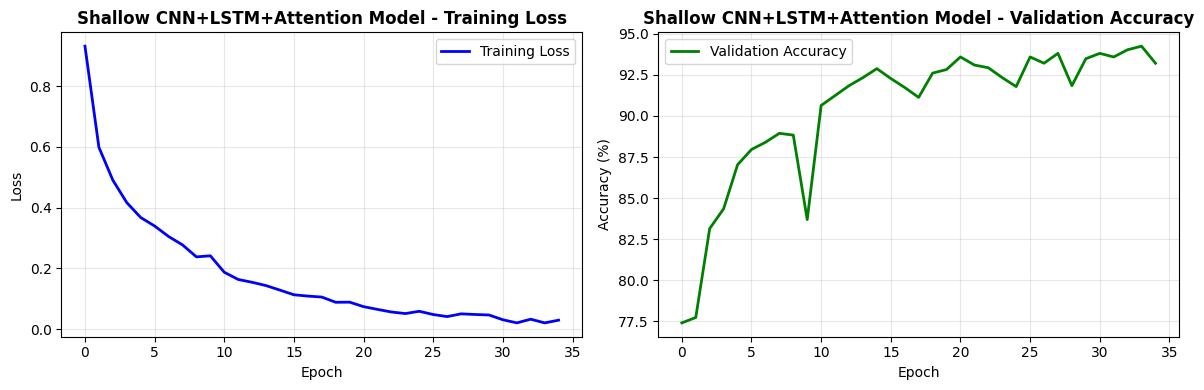

In [ ]:
plot_training_curves(train_losses, val_accuracies, "Shallow CNN+LSTM+Attention Model")

In [ ]:
model_save_path = "../saved_models/shallow_cnn_lstm_attention_model.pth"
os.makedirs(os.path.dirname(model_save_path), exist_ok=True)
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to saved_models/shallow_cnn_lstm_attention_model.pth


In [ ]:
# Load the saved model state
model_save_path = "../saved_models/shallow_cnn_lstm_attention_model.pth"
model = ShallowCNNLSTMClassifier(num_classes=num_classes, num_features=num_features, lstm_hidden=128, lstm_layers=4).to(device)
model.load_state_dict(torch.load(model_save_path))

print(f"Model loaded from {model_save_path}")

🔍 EVALUATING MODEL...

📊 CLASSIFICATION REPORT:
              precision    recall  f1-score   support

        Bach     0.9702    0.9723    0.9712       469
   Beethoven     0.9453    0.8315    0.8847       457
      Mozart     0.8962    0.9574    0.9258       469
      Chopin     0.9207    0.9676    0.9436       432

    accuracy                         0.9321      1827
   macro avg     0.9331    0.9322    0.9313      1827
weighted avg     0.9333    0.9321    0.9314      1827



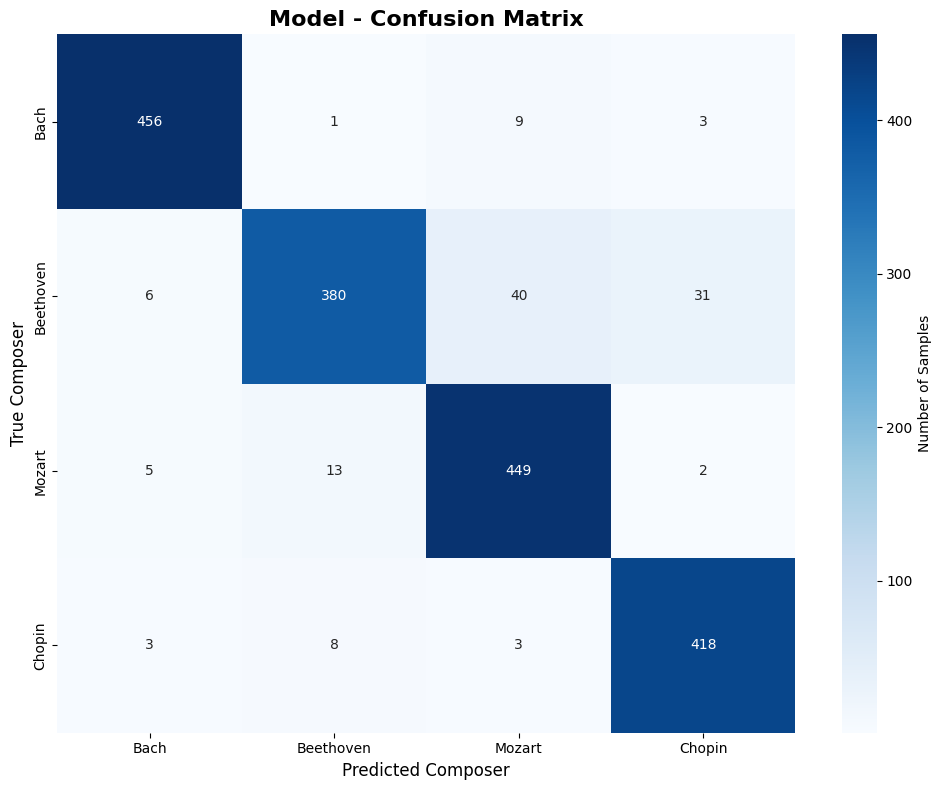


🎯 PER-CLASS ACCURACY:
Bach        : 0.9723 (97.23%)
Beethoven   : 0.8315 (83.15%)
Mozart      : 0.9574 (95.74%)
Chopin      : 0.9676 (96.76%)

🏆 OVERALL ACCURACY: 0.9321 (93.21%)

❌ MOST CONFUSED PAIRS:
Beethoven → Mozart: 40 samples
Beethoven → Chopin: 31 samples
Mozart → Beethoven: 13 samples
Bach → Mozart: 9 samples
Chopin → Beethoven: 8 samples


In [ ]:
results = evaluate_model_comprehensive(model, val_loader, TARGET_COMPOSERS, device)

## Next steps
Thus far, this is the best model performance yet, achieving **93.21% accuracy**, compared to the CNN-MLP model which had **91.08% accuracy**. This was a clear indication that we were on the right track by combining CNN and LSTM layers, alongside a separate Dense layer for interpreting the extracted features, in a multimodal approach.

The downside, however, was that the prediction of Beethoven pieces was relatively low, with only **83% accuracy**. As a next step, to address this issue, we will try training the same model while applying **weights to our CrossEntropyLoss criterion**, hoping that this adjustment will allow the model to better learn to identify Beethoven pieces.

Instead of training the model from scratch, we'll continue the training for 15 more epochs

[CNN-LSTM-MLP] Epoch [1/15], Loss: 0.0091, Val Acc: 93.92%
[CNN-LSTM-MLP] Epoch [2/15], Loss: 0.0070, Val Acc: 93.65%
[CNN-LSTM-MLP] Epoch [3/15], Loss: 0.0080, Val Acc: 94.14%
[CNN-LSTM-MLP] Epoch [4/15], Loss: 0.0116, Val Acc: 93.49%
[CNN-LSTM-MLP] Epoch [5/15], Loss: 0.0057, Val Acc: 93.60%
[CNN-LSTM-MLP] Epoch [6/15], Loss: 0.0049, Val Acc: 93.87%
[CNN-LSTM-MLP] Epoch [7/15], Loss: 0.0029, Val Acc: 93.65%
[CNN-LSTM-MLP] Epoch [8/15], Loss: 0.0047, Val Acc: 93.81%
[CNN-LSTM-MLP] Epoch [9/15], Loss: 0.0061, Val Acc: 93.87%
[CNN-LSTM-MLP] Epoch [10/15], Loss: 0.0058, Val Acc: 94.09%
[CNN-LSTM-MLP] Epoch [11/15], Loss: 0.0061, Val Acc: 94.09%
[CNN-LSTM-MLP] Epoch [12/15], Loss: 0.0040, Val Acc: 94.20%
[CNN-LSTM-MLP] Epoch [13/15], Loss: 0.0042, Val Acc: 94.25%
[CNN-LSTM-MLP] Epoch [14/15], Loss: 0.0048, Val Acc: 94.03%
[CNN-LSTM-MLP] Epoch [15/15], Loss: 0.0040, Val Acc: 94.09%


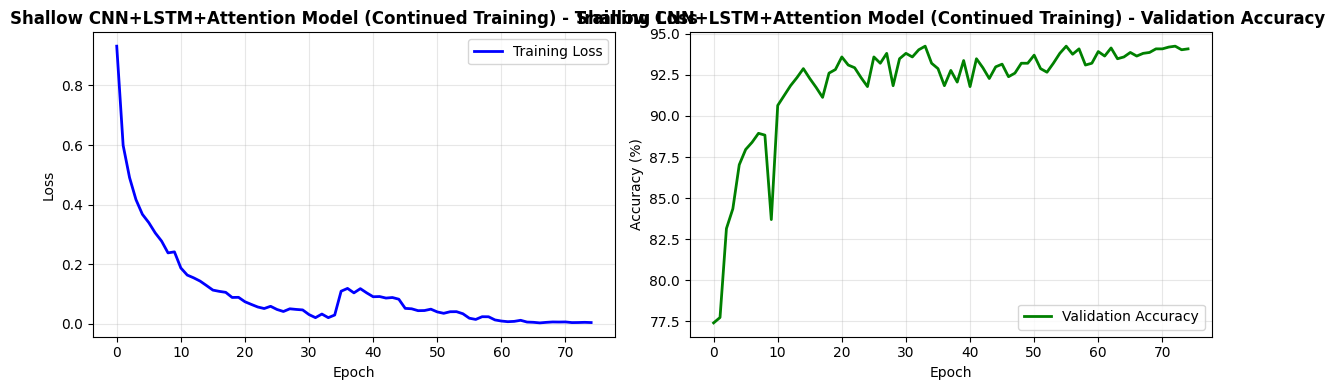

In [ ]:
# Load the saved model state
model_save_path = "../saved_models/shallow_cnn_lstm_attention_model.pth"
model = ShallowCNNLSTMClassifier(num_classes=num_classes, num_features=num_features, lstm_hidden=128, lstm_layers=4).to(device)
model.load_state_dict(torch.load(model_save_path))

class_weights = torch.tensor([1.0, 1.3, 1.0, 1.0]).to(device)

# Set up loss, optimizer, scheduler (using the same ones from previous training)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.7)

# Continue training for 10 more epochs
train_losses_cont, val_accuracies_cont = train_cnn_lstm_mlp_model(
    model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=15, device=device
)

# Optionally, combine the training history for plotting
train_losses.extend(train_losses_cont)
val_accuracies.extend(val_accuracies_cont)

# Plot the updated training curves (if you have a plotting function)
plot_training_curves(train_losses, val_accuracies, "Shallow CNN+LSTM+Attention Model (Continued Training)")

🔍 EVALUATING MODEL...

📊 CLASSIFICATION REPORT:
              precision    recall  f1-score   support

        Bach     0.9665    0.9829    0.9746       469
   Beethoven     0.9254    0.8687    0.8962       457
      Mozart     0.9443    0.9403    0.9423       469
      Chopin     0.9251    0.9722    0.9481       432

    accuracy                         0.9409      1827
   macro avg     0.9403    0.9410    0.9403      1827
weighted avg     0.9407    0.9409    0.9404      1827



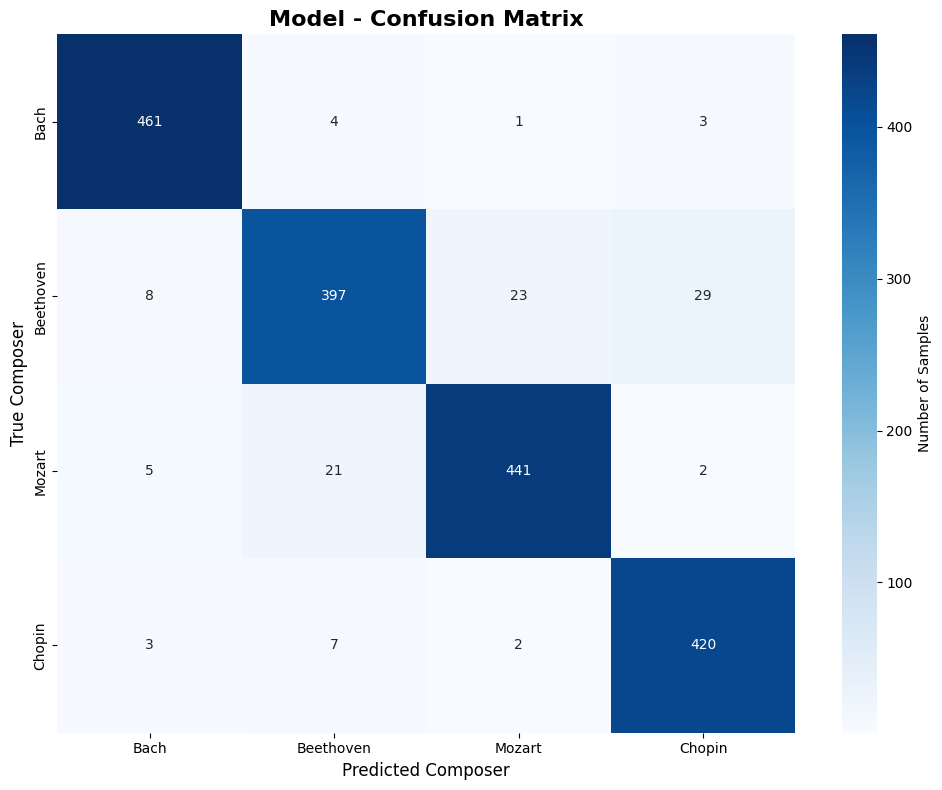


🎯 PER-CLASS ACCURACY:
Bach        : 0.9829 (98.29%)
Beethoven   : 0.8687 (86.87%)
Mozart      : 0.9403 (94.03%)
Chopin      : 0.9722 (97.22%)

🏆 OVERALL ACCURACY: 0.9409 (94.09%)

❌ MOST CONFUSED PAIRS:
Beethoven → Chopin: 29 samples
Beethoven → Mozart: 23 samples
Mozart → Beethoven: 21 samples
Beethoven → Bach: 8 samples
Chopin → Beethoven: 7 samples


In [ ]:
results = evaluate_model_comprehensive(model, val_loader, TARGET_COMPOSERS, device)

In [ ]:
model_save_path_2 = "../saved_models/shallow_cnn_lstm_attention_model_2.pth"
torch.save(model.state_dict(), model_save_path_2)
print(f"Model saved to {model_save_path_2}")

Model saved to saved_models/shallow_cnn_lstm_attention_model.pth


## Conclusion: CNN-LSTM-MLP Multimodal Model

The CNN-LSTM-MLP model achieved strong validation performance at **94.09% overall accuracy**, improving over the CNN-MLP baseline (**91.08%**) and far surpassing earlier non-multimodal attempts (~70%). Temporal modeling via deeper LSTM layers provided a clear advantage, while the multimodal fusion with engineered features sustained robust class separation.

The main weakness remains the **Beethoven** class (**86.87%**), with most confusions against Mozart and Chopin. As a next step, an **ensemble with the CNN-MLP model** (which performed better on Beethoven) will be explored to capitalize on complementary strengths and further lift class-specific

In [ ]:
paths = download_dataset()
TARGET_COMPOSERS = ['Bach', 'Beethoven', 'Chopin', 'Mozart']
data, labels, features, song_ids = load_segmented_dataset_no_overlap(paths["extract_path"], TARGET_COMPOSERS)
comprehensive_features = load_comprehensive_features(data)
train_loader, val_loader = create_songwise_data_loaders(
    data,
    labels,
    comprehensive_features,
    song_ids,
    batch_size=32,
    train_split=0.8,
    dataset_class=MultimodalDataset
)
num_classes = len(TARGET_COMPOSERS)
num_features = len(comprehensive_features[0])

In [ ]:
# let's load the models again
cnn_mlp_path = "../saved_models/cnn_mlp_composer_classifier.pth"
cnn_lstm_mlp_paths = "../saved_models/shallow_cnn_lstm_attention_model_2.pth"
cnn_mlp_model = MultimodalComposerClassifier(num_classes=num_classes, num_features=num_features).to(device)
cnn_mlp_model.load_state_dict(torch.load(cnn_mlp_path))

cnn_lstm_mlp_model = ShallowCNNLSTMClassifier(num_classes=num_classes, num_features=num_features, lstm_hidden=128, lstm_layers=4).to(device)
cnn_lstm_mlp_model.load_state_dict(torch.load(cnn_lstm_mlp_paths))